# CS345 Project Final Report: Machine Learning Analysis on Windows Portable Executable File Analysis
*Author: Tyler Rios*

*GitHub: [https://github.com/rios240/CS345-Project-Report](https://github.com/rios240/CS345-Project-Report)*

### Introduction
In the ever-evolving landscape of cybersecurity, the detection and analysis of malware are critical tasks for safeguarding digital systems. Windows Portable Executable (PE) files, being a fundamental component of Windows operating systems, are often targeted by malicious actors to execute and propagate malware. This project aims to leverage machine learning techniques to analyze a curated dataset of Windows PE malware, comparing predictive models for malware detection.

The dataset employed in this report is the SOMLAP PE Malware which comprises a diverse collection of Windows PE sample files.

More information on SOMLAP data set can be found here:
- [https://www.kaggle.com/datasets/ravikiranvarmap/somlap-data-set](https://www.kaggle.com/datasets/ravikiranvarmap/somlap-data-set)
- Kattamuri, Santosh Jhansi, Ravi Kiran Varma Penmatsa, Sujata Chakravarty, and Venkata Sai Pavan Madabathula. 2023. "Swarm Optimization and Machine Learning Applied to PE Malware Detection towards Cyber Threat Intelligence" Electronics 12, no. 2: 342.
https://doi.org/10.3390/electronics12020342

### Data Exploration

We'll begin by importing and showing general information about the dataset that could influence preprocessing and classifier configurations.

In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/rios240/CS345-Project-Report/main/SOMLAP%20DATASET.csv'

somlap = pd.read_csv(url)

somlap.head()

,blp,Fp,Rn,Prhdr,Minpar,Maxpar,Ivalss,Ivalsp,doscksum,Iip,...,bss_viraddr,bss_datsize,bss_ptrrawdat,bss_char,bss_entro,bss_phyaddr.1,bss_virsize.1,bss_viraddr.1,bss_char.1,class
0,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
1,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
2,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
3,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
4,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0


In [3]:
print(somlap.shape)
print(somlap.columns)
somlap['class'].value_counts()

(51408, 109)
Index(['blp', 'Fp', 'Rn', 'Prhdr', 'Minpar', 'Maxpar', 'Ivalss', 'Ivalsp',
       'doscksum', 'Iip',
       ...
       'bss_viraddr', 'bss_datsize', 'bss_ptrrawdat', 'bss_char', 'bss_entro',
       'bss_phyaddr.1', 'bss_virsize.1', 'bss_viraddr.1', 'bss_char.1',
       'class'],
      dtype='object', length=109)


class
0    31600
1    19808
Name: count, dtype: int64

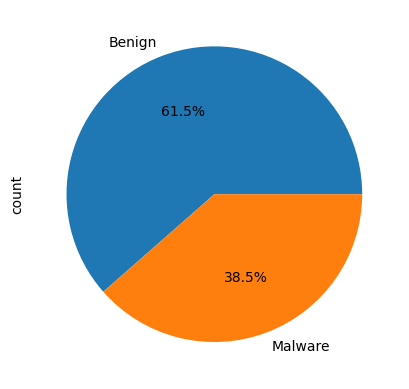

In [4]:
import matplotlib.pyplot as plt

somlap['class'].value_counts().plot(kind="pie",autopct="%1.1f%%", labels=['Benign', 'Malware'])
plt.show()

SOMLAP contains 51,408 samples 31,600 of which are Benign and 19,808 of which are Malware.

This quick dataset exploration reveals three key findings:
1. Some of the features' values are significantly larger than others meaning that the dataset could benefit from standardization.
2. The data set contains 108 features meaning it has a high dimensional space and could benefit from dimensionality reduction using PCA.
3. The ratio of benign to malware samples suggest the dataset is imbalanced and thus classifiers could be biased toward the majority class.

### Linearly Separable
We wish to compute a baseline SVC performance but it would be a good idea to first see if SOMLAP is linearly separable. To do this we use PCA to reduce the dimensions of the dataset. 

In [5]:
from sklearn.decomposition import PCA

X_somlap = somlap.drop('class', axis=1).values
y_somlap = somlap['class'].values

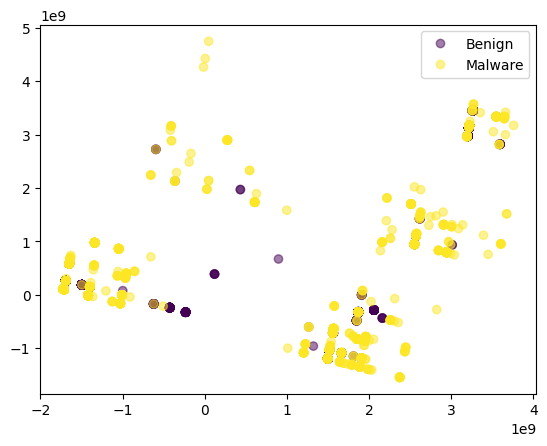

In [7]:
# Reduce down to 2 components.
n_components = 10
X_somlap_reduced = PCA(n_components=n_components).fit_transform(X_somlap)
scatter = plt.scatter(X_somlap_reduced[:, 0], X_somlap_reduced[:, 1], alpha=0.5, c=y_somlap)
plt.legend(handles=scatter.legend_elements()[0], labels=['Benign', 'Malware'])
plt.show()

The data is clearly not linearly separable so we can exclude a linear kernel from our baseline computation.

### Baselining

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [17]:
def take_baselines(X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    for kernel in ['poly', 'rbf', 'sigmoid']:
        classifier = SVC(kernel=kernel, class_weight='balanced')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy = balanced_accuracy_score(y_test, y_pred)

        print(f'{kernel} kernel accuracy: {accuracy}')

In [10]:
%timeit -r 1 -n 1 take_baseline(X_somlap, y_somlap)

poly kernel accuracy: 0.8968690040118612
rbf kernel accuracy: 0.9034585344109154
sigmoid kernel accuracy: 0.8410614958234006
3min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Standardization
So a RBF kernel provides the best accuracy for our SOMLAP data. Let's now see how standardizing the dataset can improve accuracy.

In [7]:
from sklearn.preprocessing import StandardScaler

X_somlap_std = StandardScaler().fit_transform(X_somlap)

In [8]:
def evaluate_classifier(classifier, X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred)}')

In [16]:
svc = SVC(kernel='rbf', class_weight='balanced')
%timeit -r 1 -n 1 evaluate_classifier(svc, X_somlap_std, y_somlap)

Accuracy: 0.9632100703529275
22.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Computational Time Reduction and Accuracy Improvement

With standardization we achieve better performance. However, SVC is computationaly expensive especially for a large dataset like SOMLAP. Reducing the dimensions of SOMLAP can potentially help computation time and might even increase accuracy.

In [9]:
from sklearn.pipeline import Pipeline

In [18]:
def make_pipeline(n_components, kernel='rbf'):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('svc', SVC(kernel=kernel, class_weight='balanced'))
    ])

def plot_parameters_accuracy(results):
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.title('Accuracies over n_components')
    plt.xlabel('n_components')
    plt.ylabel('Accuracy')
    plt.show()

def compute_svc_with_pca(X, y, test_size=0.25, random_state=42):
    n_components_list = [2, 10, 25, 50, 75, 108]
    results = {}
    for n_components in n_components_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        classifier = make_pipeline(n_components)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = balanced_accuracy_score(y_test, y_pred)

        results[n_components] = accuracy

    print(results)
    plot_parameters_accuracy(results)

{2: 0.8403976975405547, 10: 0.9276217609550943, 25: 0.9522016783921545, 50: 0.9612719731767351, 75: 0.9634474872570111, 108: 0.9636509874605113}


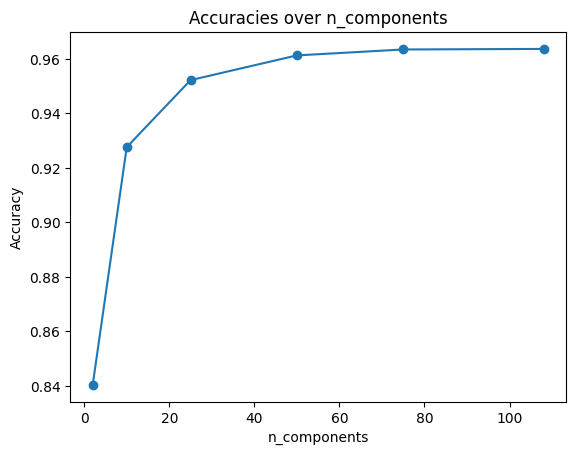

In [19]:
compute_svc_with_pca(X_somlap, y_somlap)

With PCA accuracy plateau's around 50 components so this will be used in future operations. Now we will look at the individual execution time to see if it imporves.

In [21]:
classifier = make_pipeline(50)
%timeit -r 1 -n 1 evaluate_classifier(classifier, X_somlap_std, y_somlap)

Accuracy: 0.9612719731767351
15.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Bagging ensembles which can evaluate SVCs on subsets of the data might be another way to reduce computation time.The BaggingClassifier takes in a max_samples parameter which dictates the subset of samples and max_features which dictates the subset of features. It also takes in an n_jobs parameter to run in parallel.

In [15]:
from sklearn.ensemble import BaggingClassifier

def make_pipeline_bagging(max_samples, max_features, n_components=50, random_state=42, kernel='rbf', n_jobs=3):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', BaggingClassifier(estimator=SVC(kernel=kernel, class_weight='balanced'), max_samples=max_samples,
                                          max_features=max_features, random_state=random_state, n_jobs=n_jobs))
    ])

def plot_parameters_accuracy(results):
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.title('Accuracies over max_features')
    plt.xlabel('max_features')
    plt.ylabel('Accuracy')
    plt.show()
    
def compute_bagging(X, y, max_features=0.5, test_size=0.25, random_state=42):
    max_samples_features_list = [(0.25, max_features), (0.5, max_features), (0.75, max_features)]
    results = {}
    for max_samples, max_features in max_samples_features_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        classifier = make_pipeline_bagging(max_samples, max_features)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = balanced_accuracy_score(y_test, y_pred)

        results[max_samples] = accuracy


    print(results)
    plot_parameters_accuracy(results)

{0.25: 0.9569790879314689, 0.5: 0.9613882590073066, 0.75: 0.9628369866465105}


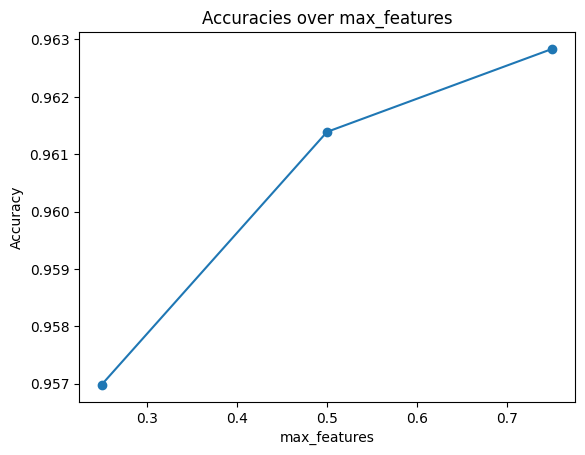

In [16]:
compute_bagging(X_somlap, y_somlap)

Taking 50% of SOMLAP samples and 50% of the features we get an accuracy close to the one for PCA. Now we will see if the execution time is better with bagging.

In [31]:
classifier = make_pipeline_bagging(0.5, 0.5)
%timeit -r 1 -n 1 evaluate_classifier(classifier, X_somlap_std, y_somlap)

Accuracy: 0.9613882590073066
23.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In the case of SOMLAP it seems better to use PCA to gain better execution time. For bagging you must take a large subset of SOMLAP samples to obtain an accuracy close to the baseline SVC but for a worse execution time.

### SVC Hyperparameters, Random Forests, and Gradient Boosting
Let's now compare our SVC performance with Random Forests, Gradient Boosting, and Histogram Gradient Boosting. 
- Random Forests builds multiple Decision Trees on subsets of the data then merges them together.
- Gradient Boosting builds a sequence of decision trees with each one correcting the errors of the previous.
- Histogram Gradient Boosting is a varient of gradient boosting that uses histograms during the splitting process, this reduces computation cost and is beneficial for large datasets like SOMLAP

All three are not only computationally fast but also very accurate. As such let's first try to maximize the accuracy for SVC by computing the optimal hyperparamters using train/validation/test splits.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [13]:
def three_way_split(X, y, r_train=0.5, r_valid=0.25, r_test=0.25, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = r_test, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size = r_valid / (r_train + r_valid), random_state=42)
    return X_train, y_train, X_valid, y_valid, X_test, y_test


def optimal_hyperparameter(classifier, C, gamma, C_values, gamma_values,
                           X_train, X_valid, y_train, y_valid):
    optimal_accuracy = 0
    optimal_C = None
    optimal_gamma = None
    for C_value in C_values:
        for gamma_value in gamma_values:
            param_dict = {C : C_value, gamma: gamma_value}
            classifier.set_params(**param_dict)
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_valid)
            current_accuracy = balanced_accuracy_score(y_valid, y_pred)

            if current_accuracy > optimal_accuracy:
                optimal_accuracy = current_accuracy
                optimal_C = C_value
                optimal_gamma = gamma_value
    return optimal_C, optimal_gamma


def evaluate_svc(classifier, X, y, C_values, gamma_values, r_train=0.5, r_valid=0.25, r_test=0.25, 
                 C='svc__C', gamma='svc__gamma'):
    X_train, y_train, X_valid, y_valid, X_test, y_test = three_way_split(X, y)

    C_value, gamma_value = optimal_hyperparameter(classifier, C, gamma, C_values, gamma_values, X_train, X_valid, y_train, y_valid)

    param_dict = {C : C_value, gamma: gamma_value}
    classifier.set_params(**param_dict)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print(f'Accuracy {balanced_accuracy_score(y_test, y_pred)} with C {C_value} and gamma {gamma_value}')

#### Hyperparameter Selection with SVC

In [14]:
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf', class_weight='balanced'))
])

gamma_values = [0.001, 1.0, 10.0]
C_values = [10, 100, 1000]

%timeit -r 1 -n 1 evaluate_svc(classifier, X_somlap, y_somlap, C_values, gamma_values)

Accuracy 0.9753716301335349 with C 1000 and gamma 1.0
5min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Random Forest Classification

In [10]:
random_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(n_estimators=100, max_samples=0.25,
                                             random_state=42, class_weight='balanced', n_jobs=3))
])
%timeit -r 1 -n 1 evaluate_classifier(random_forest, X_somlap, y_somlap)

Accuracy: 0.9929743977363026
750 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Gradient Boosting Classification

In [11]:
gradient_boosting = Pipeline([
    ('scaler', StandardScaler()),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

%timeit -r 1 -n 1 evaluate_classifier(gradient_boosting, X_somlap, y_somlap)

Accuracy: 0.9898056088532279
19.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Gradient Boosting Using Histograms

In [12]:
hist_gradient_boosting = Pipeline([
    ('scaler', StandardScaler()),
    ('gradient_boosting', HistGradientBoostingClassifier(max_iter=100, random_state=42, l2_regularization=0.001))
])

%timeit -r 1 -n 1 evaluate_classifier(hist_gradient_boosting, X_somlap, y_somlap)

Accuracy: 0.99476229238134
1.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Summary
In this report we evaluated various machine learning estimators on SOMLAP a Windows PE Malware dataset. We took a baseline SVC and found that using a a RBF kernel provided the most accurate result. We then employed a number of techniques such as Principle Component Analysis and Standardization to try to reduce computational time for our baseline SVC. In the process we found that simple PCA with 50 components was more efficient then attempting to use a bagging-meta estimator with the SVC. We used train/validation/test splits to find optimal hyperparameters (C and gamma values) for the SVC gaining additional accuacy. Finnally, we used RandomForestClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier on SOMLAP and discoverge that not only are they much less computationally extraneous then SVCs but they provide even better acccuracy.  